In [12]:
import numpy as np
import random
import math
from scipy.stats import norm
from scipy.integrate import quad
from scipy.optimize import minimize, basinhopping
import matplotlib.pyplot as plt

In [42]:
def sample_z(n, annot, p, s2, s02, r2_het_ss):
    z_sample = [random.gauss(0, math.sqrt(s02)) for _ in range(n)]
    for i in range(n):
        z = 0
        for a, r2 in zip(annot,r2_het_ss):
            if random.random() < p[a]:
                z += random.gauss(0, math.sqrt(s2[a]*r2))
        z_sample[i] += z
    return z_sample


def logistic(x):
    """ Logistic function. Maps [-∞; ∞] -> [0; 1].
    """
    return 1/(1 + math.exp(-x))


def logit(x):
    """ Inverse logistic function (logit). Maps [0; 1] -> [-∞; ∞].
    """
    return math.log(x/(1 - x))


def ift(x, z, annot, p, s2, s02, r2_het_ss):
    res = math.cos(x*z)*math.exp(-0.5*x*x*s02)
    for a, r2 in zip(annot, r2_het_ss):
        res *= 1-p[a] + p[a]*math.exp(-0.5*x*x*s2[a]*r2)
    return res


def get_log_likelihood(z_vec, annot, p, s2, s02, r2_het_ss):
    log_likelihood = 0
    for z in z_vec:
        ift_z = lambda x: ift(x, z, annot, p, s2, s02, r2_het_ss)
        log_likelihood += -math.log(quad(ift_z, 0, np.inf)[0]/math.pi)
    return log_likelihood/len(z_vec)


def ift_p(x, z, annot, p, s2, s02, r2_het_ss, p_ind):
    """ (f*g*h)' = f'*g*h + f*g'*h + f*g*h'
           der       i0       i1       i2                
    """
    der = 0 # derivative = (f*g*h)'
    half_xx = 0.5*x*x
    for i in range(len(annot)):
        if annot[i] == p_ind:
            res = 1
            for j, (a, r2) in enumerate(zip(annot, r2_het_ss)):
                if j != i:
                    res *= 1-p[a] + p[a]*math.exp(-half_xx*s2[a]*r2)
                else:
                    res *= -1 + math.exp(-half_xx*s2[a]*r2)
            der += res
    der *= math.cos(x*z)*math.exp(-half_xx*s02)
    return der

def ift_s2(x, z, annot, p, s2, s02, r2_het_ss, s2_ind):
    der = 0
    half_xx = 0.5*x*x
    for i in range(len(annot)):
        if annot[i] == s2_ind:
            res = 1
            for j, (a, r2) in enumerate(zip(annot, r2_het_ss)):
                if j != i:
                    res *= 1-p[a] + p[a]*math.exp(-half_xx*s2[a]*r2)
                else:
                    res *= p[a]*math.exp(-half_xx*s2[a]*r2)*(-half_xx*r2)
            der += res
    der *= math.cos(x*z)*math.exp(-half_xx*s02)
    return der

def ift_s02(x, z, annot, p, s2, s02, r2_het_ss):
    der = math.cos(x*z)*math.exp(-0.5*x*x*s02)*(-0.5*x*x)
    for a, r2 in zip(annot, r2_het_ss):
        der *= 1-p[a] + p[a]*math.exp(-0.5*x*x*s2[a]*r2)
    return der


def get_log_likelihood_derivative(z_vec, annot, p, s2, s02, r2_het_ss):
    """ 
    assume we have n anootation categories and f is our likelihood function, then:
    gradient = [f_p1, f_p2, ..., f_pn, f_s21, f_s22, ..., f_s2n, f_s02], f = -log_likelihood
    f' = [-log(g)]' = -(1/g * g'), g = likelihood
    """
    n_annot = len(set(annot))
    gradient = [0 for _ in range(2*n_annot+1)]
        
    for z in z_vec:
        ift_z = lambda x: ift(x, z, annot, p, s2, s02, r2_het_ss)
        likelihood_z = quad(ift_z, 0, np.inf)[0]/math.pi
        for i in range(n_annot):
            # get p derivative
            ift_z_pi = lambda x: ift_p(x, z, annot, p, s2, s02, r2_het_ss, i)
            likelihood_z_pi = quad(ift_z_pi, 0, np.inf)[0]/math.pi
            gradient[i] += -likelihood_z_pi/likelihood_z
            
            # get s2 derivative
            ift_z_s2i = lambda x: ift_s2(x, z, annot, p, s2, s02, r2_het_ss, i)
            likelihood_z_s2i = quad(ift_z_s2i, 0, np.inf)[0]/math.pi
            gradient[i+n_annot] += -likelihood_z_s2i/likelihood_z
        # get s02 derivative
        ift_z_s02 = lambda x: ift_s02(x, z, annot, p, s2, s02, r2_het_ss)
        likelihood_z_s02 = quad(ift_z_s02, 0, np.inf)[0]/math.pi
        gradient[-1] += -likelihood_z_s02/likelihood_z
    # devide all elements of gradient by len(z_vec)    
    return np.array([x/len(z_vec) for x in gradient])

In [46]:
# test _cmmcost_omp with z2use = {true, false, false}
z_vec = [1.275]
annot = [0,1,0]
r2_het_ss = [1.593, 0.934, 2.463]
p = [1, 1]
s2 = [1.17, 2.03]
s02 = 1.03

gradient = get_log_likelihood_derivative(z_vec, annot, p, s2, s02, r2_het_ss)
print(gradient)

[0.29829209 0.11311471 0.20833627 0.04797487 0.05136496]


In [34]:
annot = [0, 0, 0, 0] # [0, 0, 0, 0, 0]
r2_het_ss = [3421, 6436, 10234, 554, 9257] # [1, 1, 1, 1, 1] # [3421, 6436, 10234, 554, 9257]
p =  [0.4]
s2 = [1E-4]
s02 = 1.0
n_z_samples = 4000
assert len(set(annot)) == len(p) == len(s2)

In [35]:
z_sample = sample_z(n_z_samples, annot, p, s2, s02, r2_het_ss)

mean = 0.021350377436065927
std =  1.3445206756011023


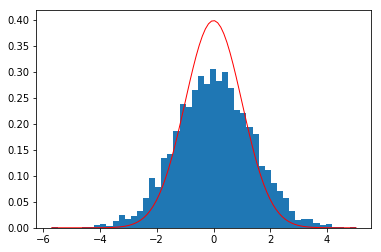

In [36]:
plt.hist(z_sample,50,density=True)
x = np.linspace(min(z_sample), max(z_sample), 100)
plt.plot(x, norm.pdf(x, 0, math.sqrt(s02)), 'r', lw=1, label='pdf')
print(f"mean = {np.mean(z_sample)}\nstd =  {np.std(z_sample)}")

In [37]:
p_in_opt = [1]
s2_in_opt = [0.6]
z_vec = z_sample # [0.5] # z_sample
l_opt = get_log_likelihood(z_vec, annot, p, s2, s02, r2_het_ss)
l1 = get_log_likelihood(z_vec, annot, p_in_opt, s2_in_opt, s02, r2_het_ss)
print(f"optimum likelihood = {l_opt}")
print(f"optimized likelihood = {l1}")
gradient = get_log_likelihood_derivative(z_vec, annot, p, s2, s02, r2_het_ss)
print(gradient)

optimum likelihood = 1.7151117535333056
optimized likelihood = 5.631253285333626
[ 3.17440327e-04  2.66930414e+01 -1.29032125e-03]


In [38]:
# optmization
p_init = p
s2_init = s2
s02_init = s02

# p_init = [0.8] # [random.random() for _ in p]
# s2_init = [1E-3] # [random.random() for _ in s2]
# s02_init = 1.1 # random.random()

def cost_func(x, z_sample, annot, r2_het_ss):
    """ x = p + s2 + s02
    """
    n_annot = len(set(annot))
    p_in_opt = [logistic(y) for y in x[:n_annot]]
    s2_in_opt = [math.exp(y) for y in x[n_annot:-1]]
    s02_in_opt = math.exp(x[-1])
    minus_log_lik = get_log_likelihood(z_sample, annot, p_in_opt, s2_in_opt, s02_in_opt, r2_het_ss)
    print(p_in_opt,s2_in_opt,s02_in_opt,minus_log_lik)
    return minus_log_lik

def grad_func(x, z_sample, annot, r2_het_ss):
    """ x = p + s2 + s02
    """
    n_annot = len(set(annot))
    p_in_opt = [logistic(y) for y in x[:n_annot]]
    s2_in_opt = [math.exp(y) for y in x[n_annot:-1]]
    s02_in_opt = math.exp(x[-1])
    grad = get_log_likelihood_derivative(z_sample, annot, p_in_opt, s2_in_opt, s02_in_opt, r2_het_ss)
    
    # [1/(1 + math.exp(-x))]' = math.exp(-x)/(1 + math.exp(-x))**2
    p_transform_der = [math.exp(-y)/(1 + math.exp(-y))**2 for y in x[:n_annot]]
    s2_transform_der = [math.exp(y) for y in x[n_annot:-1]]
    s02_transform_der = [math.exp(x[-1])]
    transform_der = p_transform_der + s2_transform_der + s02_transform_der
    grad = np.array([g*d for g,d in zip(grad, transform_der)])
   
    print(f"gradient: {grad}")
    return grad

p_init_in_opt = [logit(y) for y in p_init]
s2_init_in_opt = [math.log(y) for y in s2_init]
s02_init_in_opt = [math.log(s02_init)]

x_init_in_opt = p_init_in_opt + s2_init_in_opt + s02_init_in_opt

# res_nm = minimize(cost_func, x_init_in_opt, args=(z_sample, annot, r2_het_ss), method='Nelder-Mead',
#                options={"maxiter":50, "fatol":1E-2, "xatol":1E-5})

In [39]:
# res_nm = minimize(cost_func, x_init_in_opt, args=(z_sample, annot, r2_het_ss), method='Nelder-Mead',
#                options={"maxiter":50, "fatol":1E-2, "xatol":1E-5})
res_bfgs = minimize(cost_func, x_init_in_opt, args=(z_sample, annot, r2_het_ss), method='BFGS',
               jac=grad_func, options={"maxiter":20, "gtol":1E-4}) # , "norm":2.

# minimizer_kwargs = {"args":(z_sample, annot, r2_het_ss), "method": "Nelder-Mead", "options":{"maxiter":10}}
# res_basin = basinhopping(cost_func, x_init_in_opt, niter=20,minimizer_kwargs=minimizer_kwargs)

# minimizer_kwargs = {"args":(z_sample, annot, r2_het_ss), "method": "BFGS", "jac":grad_func,
#                     "options":{"maxiter":5}}
# res_basin = basinhopping(cost_func, x_init_in_opt, niter=20,minimizer_kwargs=minimizer_kwargs)

gradient: [ 7.61856785e-05  2.66930414e-03 -1.29032125e-03]
[0.4] [0.00010000000000000009] 1.0 1.7151117535333056
[0.3999817155764764] [9.97334255282559e-05] 1.001291154068875 1.7151030437942152
gradient: [ 2.75518151e-05  2.56355353e-03 -1.37866753e-03]
[0.39990858066935914] [9.867421491811173e-05] 1.006472462671126 1.7150698908727189
gradient: [-0.00016163  0.00215029 -0.00172907]
[0.3996160856848073] [9.454867667820603e-05] 1.0274672014730442 1.71496178721215
gradient: [-0.00083443  0.00065137 -0.00307696]
[0.3994071536396528] [8.436551710413212e-05] 1.0940579778373944 1.714767307419681
gradient: [-0.00142892 -0.00129023 -0.00458011]
[0.3996059232918868] [7.365734548920146e-05] 1.1879055702041739 1.7146158048360258
gradient: [-0.00069468 -0.00090245 -0.00267273]
[0.39978910193951966] [6.507926199481402e-05] 1.282064506342932 1.714594978429007
gradient: [0.00058102 0.00078043 0.00219905]
[0.3997037382176686] [6.865734752234275e-05] 1.2403437717512213 1.7145837522251353
gradient: [-1.

In [39]:
res = res_basin
print(res)
n_annot = len(set(annot))
p_in_opt = [logistic(y) for y in res.x[:n_annot]]
s2_in_opt = [math.exp(y) for y in res.x[n_annot:-1]]
s02_in_opt = math.exp(res.x[-1])
print(p_in_opt, s2_in_opt, s02_in_opt)

                        fun: 1.7057695531489812
 lowest_optimization_result:  final_simplex: (array([[ 8.05554434e-01, -9.78798284e+00, -1.08785781e-03],
       [ 8.22611694e-01, -9.79110554e+00, -1.07341677e-03],
       [ 8.14804147e-01, -9.84868987e+00, -1.05138089e-03],
       [ 8.13725418e-01, -9.85157236e+00, -1.08380310e-03]]), array([1.70576955, 1.70579141, 1.70581887, 1.70582899]))
           fun: 1.7057695531489812
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 21
           nit: 10
        status: 2
       success: False
             x: array([ 8.05554434e-01, -9.78798284e+00, -1.08785781e-03])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 21
                       nfev: 425
                        nit: 20
                          x: array([ 8.05554434e-01, -9.78798284e+00, -1.08785781e-03])
[0.6911613730321382] [5.6121990474486066e-05] 0.9989127336954803


In [40]:
print(res_bfgs)
n_annot = len(set(annot))
p_in_opt = [logistic(y) for y in res_bfgs.x[:n_annot]]
s2_in_opt = [math.exp(y) for y in res_bfgs.x[n_annot:-1]]
s02_in_opt = math.exp(res_bfgs.x[-1])
print(p_in_opt, s2_in_opt, s02_in_opt)
print(f"Optimal: {p} {s2} {s02}")

      fun: 1.7145830407175544
 hess_inv: array([[  0.99141755,   0.26499002,  -0.18519934],
       [  0.26499002,  94.66431233, -53.34045451],
       [ -0.18519934, -53.34045451,  31.23321301]])
      jac: array([7.73701589e-05, 6.63873801e-05, 7.98069659e-05])
  message: 'Optimization terminated successfully.'
     nfev: 9
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([-0.4067195 , -9.59663895,  0.22152427])
[0.39969898324146097] [6.795675940534694e-05] 1.2479775366365509
Optimal: [0.4] [0.0001] 1.0


In [178]:
s2 = 2
x = 0.5
normal_pdf_der = lambda x: -(math.pi/(math.sqrt(2*math.pi*s2))**3)*math.exp(-x*x/(2*s2)) + \
                                  (math.exp(-x*x/(2*s2))/math.sqrt(2*math.pi*s2))*(x*x/(2*s2*s2))
normal_pdf_der1 = lambda x: (math.exp(-x*x/(2*s2))/math.sqrt(2*math.pi*s2))*(x*x/(2*s2*s2) - 1/(2*s2))

In [179]:
normal_pdf_der(x), normal_pdf_der1(x)

(-0.057969522700256265, -0.05796952270025625)

In [180]:
(norm.pdf(x,0,math.sqrt(s2+1E-5)) - norm.pdf(x,0,math.sqrt(s2)))/1E-5

-0.057969335076624155

In [181]:
-normal_pdf_der1(x)/norm.pdf(x,0,math.sqrt(s2))

0.21875

In [20]:
grad_func(p+s2+[s02], z_sample, annot, r2_het_ss)

gradient: [1.356751518275716, 0.2422887974812564, 0.1300191125852796]


[1.356751518275716, 0.2422887974812564, 0.1300191125852796]

In [9]:
# Test from _cmmcost_omp.c with z2use = {true, true, true}
def normal_pdf_derivative(x, s2):
    return (math.exp(-x*x/(2*s2))/math.sqrt(2*math.pi*s2))*(x*x/(2*s2*s2) - 1/(2*s2))
z_vec = [1.275, -0.496, 2.983]
# SNP   S2_eff (see _cmmcost_omp.c, main())
# 0     1.593*1.17 + 0.934*2.03 + 2.463*1.17 + 1.03 = 7.671539999999999
# 1     0.719*0.954 + 1.847*2.03 + 1.03 = 5.465336
# 2     3.012*2.03 + 1.927*1.17 + 0.896*1.17 + 1.401*0.954 + 1.03 = 11.783824
#
# sb2 = {1.17, 2.03, 0.954}
s2_eff_vec = [7.671539999999999, 5.465336, 11.783824]
likelihood_der_sb2_0 = 0
likelihood_der_sb2_0 += -(1.593 + 2.463)*normal_pdf_derivative(z_vec[0], s2_eff_vec[0])/norm.pdf(z_vec[0],0,math.sqrt(s2_eff_vec[0]))
likelihood_der_sb2_0 += -(1.927 + 0.896)*normal_pdf_derivative(z_vec[2], s2_eff_vec[2])/norm.pdf(z_vec[2],0,math.sqrt(s2_eff_vec[2]))
likelihood_der_sb2_0 /= 3
print(f"Likelihood derivative sb2[0] = {likelihood_der_sb2_0}")

likelihood_der_sb2_1 = 0
likelihood_der_sb2_1 += -(0.934)*normal_pdf_derivative(z_vec[0], s2_eff_vec[0])/norm.pdf(z_vec[0],0,math.sqrt(s2_eff_vec[0]))
likelihood_der_sb2_1 += -(1.847)*normal_pdf_derivative(z_vec[1], s2_eff_vec[1])/norm.pdf(z_vec[1],0,math.sqrt(s2_eff_vec[1]))
likelihood_der_sb2_1 += -(3.012)*normal_pdf_derivative(z_vec[2], s2_eff_vec[2])/norm.pdf(z_vec[2],0,math.sqrt(s2_eff_vec[2]))
likelihood_der_sb2_1 /= 3
print(f"Likelihood derivative sb2[1] = {likelihood_der_sb2_1}")

likelihood_der_sb2_2 = 0
likelihood_der_sb2_2 += -(0.719)*normal_pdf_derivative(z_vec[1], s2_eff_vec[1])/norm.pdf(z_vec[1],0,math.sqrt(s2_eff_vec[1]))
likelihood_der_sb2_2 += -(1.401)*normal_pdf_derivative(z_vec[2], s2_eff_vec[2])/norm.pdf(z_vec[2],0,math.sqrt(s2_eff_vec[2]))
likelihood_der_sb2_2 /= 3
print(f"Likelihood derivative sb2[2] = {likelihood_der_sb2_2}")

likelihood_der_s02 = 0
likelihood_der_s02 += -normal_pdf_derivative(z_vec[0], s2_eff_vec[0])/norm.pdf(z_vec[0],0,math.sqrt(s2_eff_vec[0]))
likelihood_der_s02 += -normal_pdf_derivative(z_vec[1], s2_eff_vec[1])/norm.pdf(z_vec[1],0,math.sqrt(s2_eff_vec[1]))
likelihood_der_s02 += -normal_pdf_derivative(z_vec[2], s2_eff_vec[2])/norm.pdf(z_vec[2],0,math.sqrt(s2_eff_vec[2]))
likelihood_der_s02 /= 3
print(f"Likelihood derivative s02 = {likelihood_der_s02}")

Likelihood derivative sb2[0] = 0.07922259969273605
Likelihood derivative sb2[1] = 0.08021267602154018
Likelihood derivative sb2[2] = 0.025791314143875393
Likelihood derivative s02 = 0.049707571334653616


In [28]:
norm.cdf(-7)

1.279812543885835e-12